In [113]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime


# Time series

We will be using the historic performance of the S&P500

In [114]:
data = yf.download("^GSPC", repair=True, multi_level_index=False)

[*********************100%***********************]  1 of 1 completed


In [115]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1950-01-03,16.66,16.66,16.66,16.66,16.66,1260000
1950-01-04,16.85,16.85,16.85,16.85,16.85,1890000
1950-01-05,16.93,16.93,16.93,16.93,16.93,2550000
1950-01-06,16.98,16.98,16.98,16.98,16.98,2010000
1950-01-09,17.08,17.08,17.08,17.08,17.08,2520000


In [116]:
data.index

DatetimeIndex(['1950-01-03', '1950-01-04', '1950-01-05', '1950-01-06',
               '1950-01-09', '1950-01-10', '1950-01-11', '1950-01-12',
               '1950-01-13', '1950-01-16',
               ...
               '2024-10-16', '2024-10-17', '2024-10-18', '2024-10-21',
               '2024-10-22', '2024-10-23', '2024-10-24', '2024-10-25',
               '2024-10-28', '2024-10-29'],
              dtype='datetime64[ns]', name='Date', length=18828, freq=None)

<AxesSubplot: xlabel='Date', ylabel='Adj Close'>

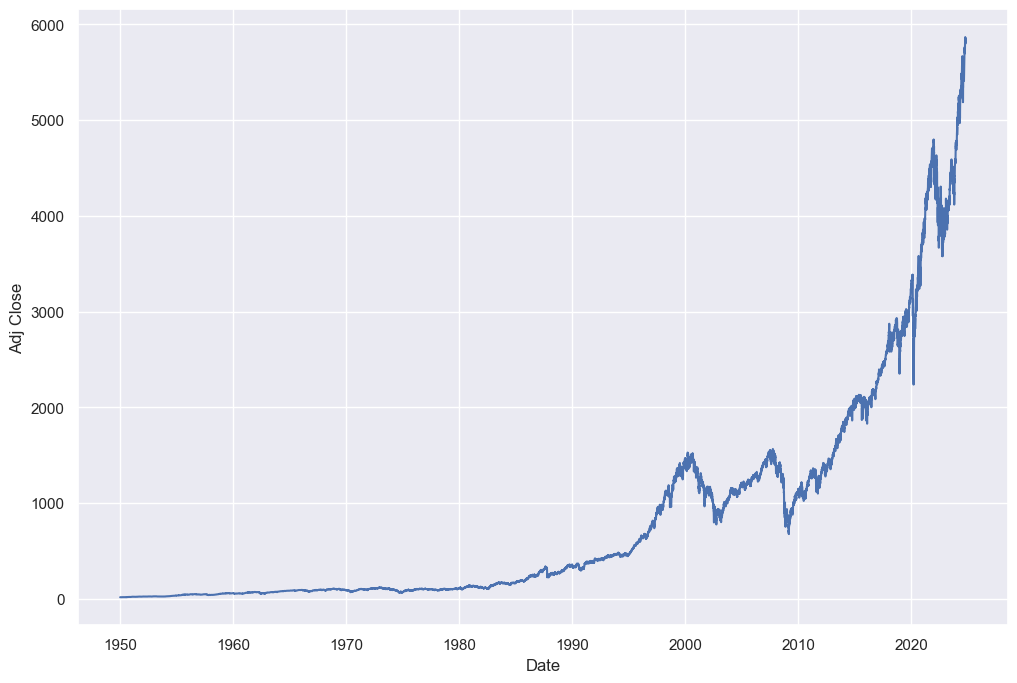

In [117]:
sns.lineplot(data["Adj Close"])

# Selecting specific timeframes

<AxesSubplot: xlabel='Date', ylabel='Adj Close'>

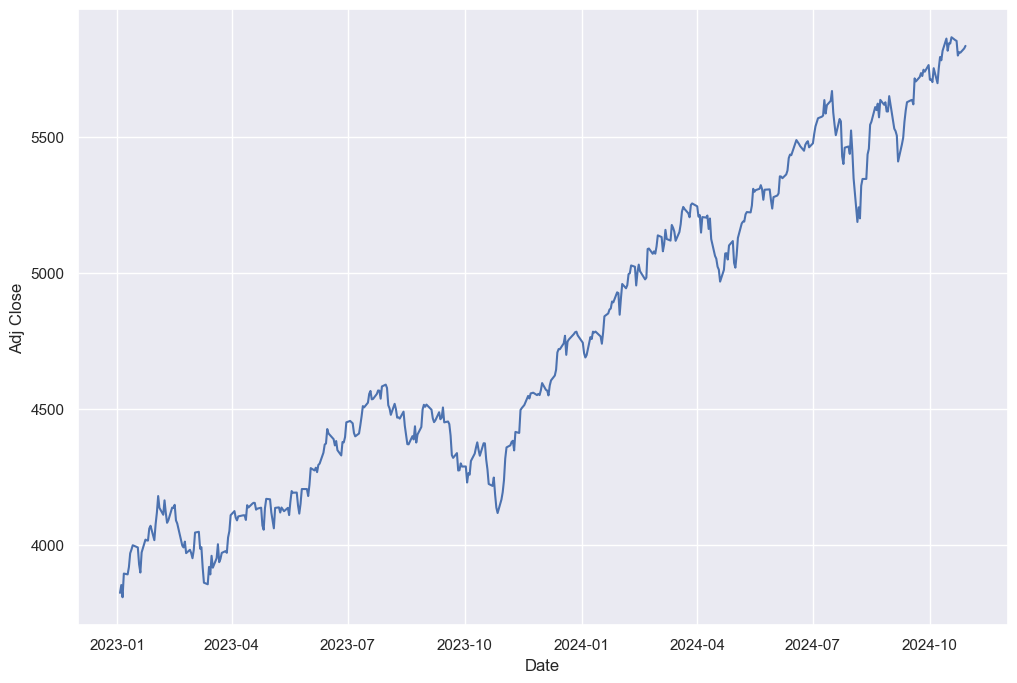

In [118]:
sns.lineplot(data["Adj Close"]["2023-01-01":])

---

# Log returns

Unlike percentage returns, log returns consider compounded returns and can be added together (a property of indicies). This makes them **very** easy to work with

$$
\ln(\cfrac{P_t}{P_{t-1}})
$$


The shift method allows us to move the data down by $x$ rows. A negative value will move the data up.

In [119]:
data["log_returns"] = np.log( (data["Adj Close"] / data["Adj Close"].shift(1)))

Converting into simple return

In [120]:
np.exp(data["log_returns"].sum()) - 1

349.11524461574874

Simple return

In [121]:
(data["Adj Close"].iloc[-1] / data["Adj Close"].iloc[0]) - 1

349.1152446157471

---

# Re sampling

Time series data can be re-sampled into different frequencies such as daily -> monthly. Pandas even has a ohlc method to use. As we are only interested in returns right now we will use .sum()

In [122]:
Q_data = data.resample("Q").sum()
# data.resample("Q").last()
Q_data

,Open,High,Low,Close,Adj Close,Volume,log_returns
Date,,,,,,,
1950-03-31,1062.830002,1062.830002,1062.830002,1062.830002,1062.830002,106420000,0.037118
1950-06-30,1156.830004,1156.830004,1156.830004,1156.830004,1156.830004,130520000,0.022871
1950-09-30,1153.330013,1153.330013,1153.330013,1153.330013,1153.330013,122060000,0.094848
1950-12-31,1207.929998,1207.929998,1207.929998,1207.929998,1207.929998,141300000,0.049157
1951-03-31,1316.090012,1316.090012,1316.090012,1316.090012,1316.090012,135110000,0.050118
...,...,...,...,...,...,...,...
2023-12-31,280934.951172,282378.721191,279788.979980,281289.180176,281289.180176,246020700000,0.106479
2024-03-31,304239.279785,305435.291504,303160.209473,304545.000000,304545.000000,250104320000,0.096746
2024-06-30,330609.499023,331914.121094,328990.120605,330537.470703,330537.470703,244622510000,0.038480


Text(0, 0.5, 'return')

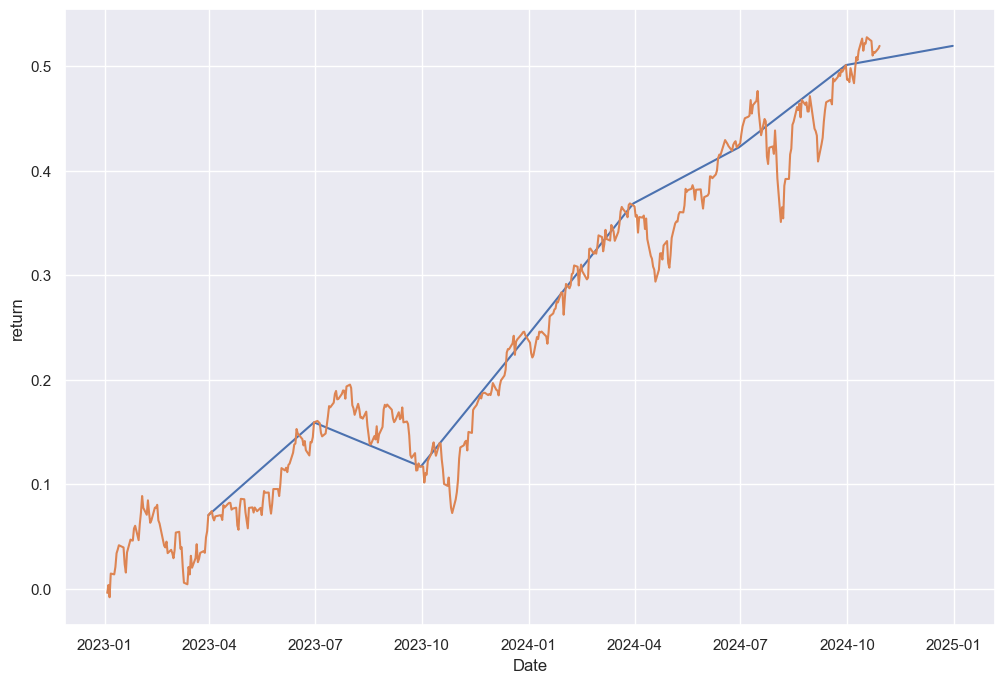

In [138]:
ax = sns.lineplot(np.exp(Q_data["log_returns"]["2023-01-01":].cumsum()) - 1) # Converting to simple returns then plotting
ax = sns.lineplot(np.exp(data["log_returns"]["2023-01-01":].cumsum()) - 1)
# sns.lineplot(M_return)

ax.set_ylabel("return")

In [124]:
np.round(Q_data["log_returns"].sum(),2)

5.86

The continously compounded return for the last 98 years has been 5.8

In [125]:
np.exp(np.round(Q_data["log_returns"].sum(),2)) - 1

349.7241440199136

# Rolling stats

<AxesSubplot: xlabel='Date', ylabel='log_returns'>

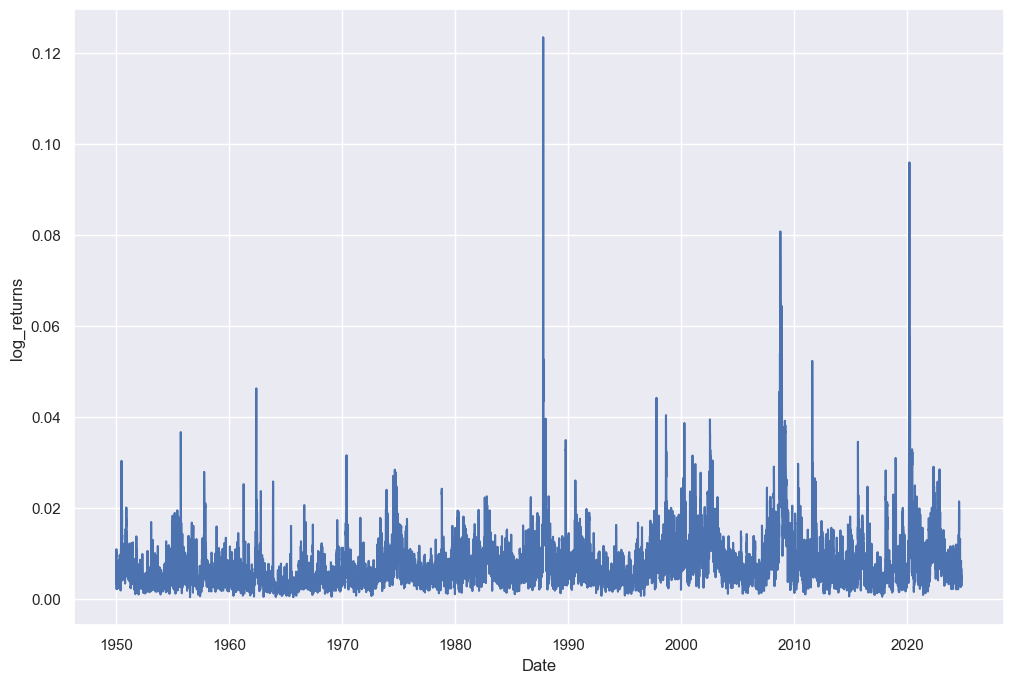

In [140]:
window = 5

sns.lineplot(data["log_returns"]["2024-01-01":].rolling(window).std())

# Creating returns calander & Pivot tables

To create this calander we are going to take advantage of the heatmap plot from seaborn by giving it specific index and columns to build from. 

To build this calander we are going to need columns as months and years as an index

getting months

In [126]:
months = [datetime(1,x,1).strftime("%B") for x in range(1,13)]
months

['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

Create pivot table based on year and month

In [127]:
data["Year"] = data.index.year
data["Month"] = data.index.month_name()

heatmap_data = pd.pivot_table(data, values="log_returns", index="Year", columns="Month",aggfunc="sum")

heatmap_data = heatmap_data[months] # Ensuring the order of the months
heatmap_data = heatmap_data.apply(lambda x : np.exp(x) - 1) # Converting to simple returns

plot pivot table to get the return for each month every year

<AxesSubplot: xlabel='Year', ylabel='Month'>

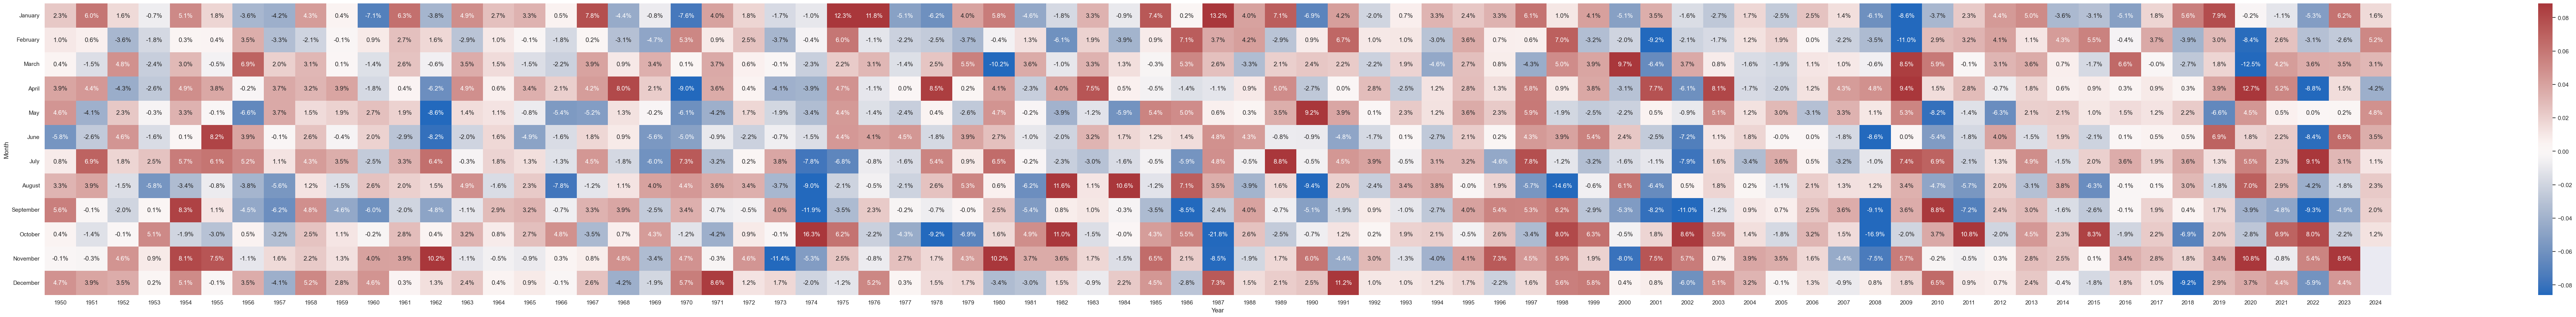

In [128]:
sns.set_theme(rc={'figure.figsize':(100, 10)})
sns.heatmap(heatmap_data.T,annot=True,robust=True,fmt=".1%",cmap="vlag")

Median returns for each month over the last 98 years of the S&P500

In [129]:
month_returns = heatmap_data.median() * 100

month_returns.sort_values(ascending=False)

Month
November     2.026953
January      1.589571
March        1.516710
December     1.478837
July         1.312815
April        1.215565
October      1.125175
May          1.049138
August       0.583545
February     0.354893
June         0.075523
September   -0.347964
dtype: float64

Text(0.5, 1.0, 'Median expected return of a month')

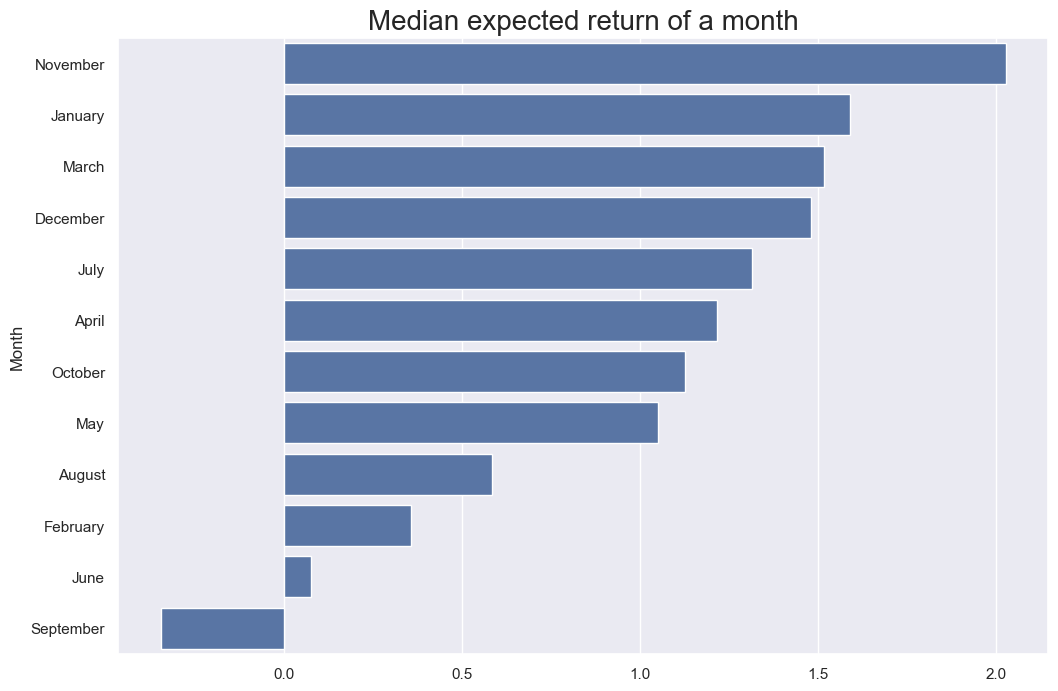

In [130]:
sns.set_theme(rc={'figure.figsize':(12, 8)})
ax = sns.barplot(month_returns, order=month_returns.sort_values(ascending=False).index,orient="h")
ax.set_title("Median expected return of a month",fontsize=20)

Distribution of returns per month

<AxesSubplot: xlabel='Month'>

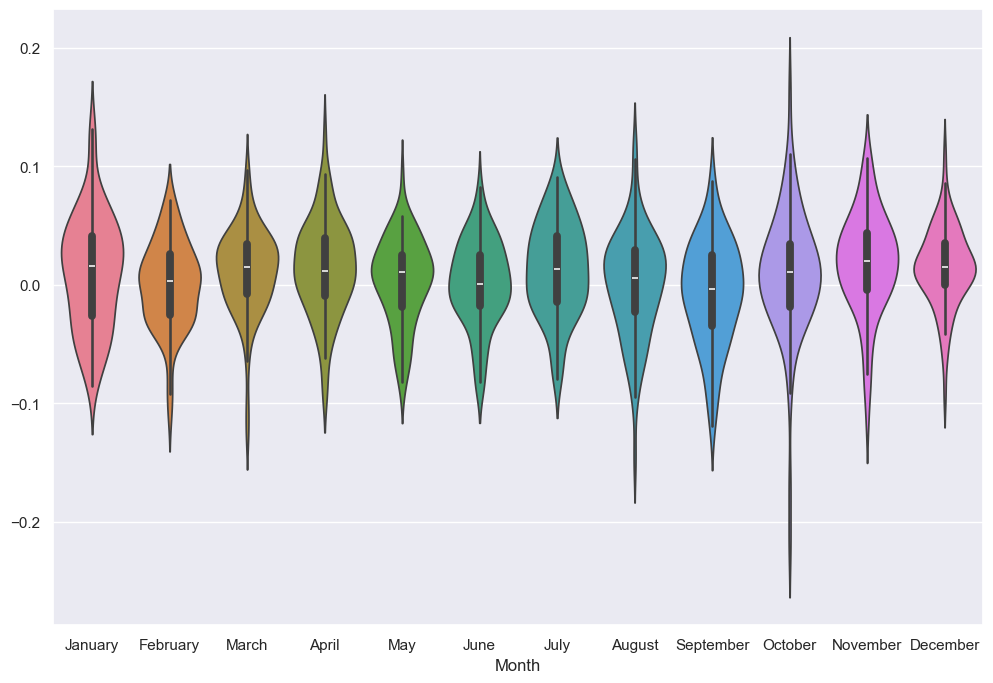

In [131]:
sns.violinplot(heatmap_data)

# Consider risk

In [132]:
heatmap_data.describe()

Month,January,February,March,April,May,June,July,August,September,October,November,December
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,74.000000,74.000000
mean,0.010673,-0.000081,0.011291,0.014554,0.002983,0.001388,0.012960,0.000158,-0.006808,0.009065,0.018326,0.014875
std,0.047775,0.036273,0.036365,0.040331,0.036362,0.036158,0.039458,0.044931,0.043922,0.054601,0.043054,0.033628
min,-0.085657,-0.109931,-0.125119,-0.090483,-0.085990,-0.085962,-0.079004,-0.145797,-0.119335,-0.217630,-0.113861,-0.091777
25%,-0.026353,-0.025437,-0.008063,-0.009246,-0.018855,-0.018037,-0.014266,-0.022534,-0.034685,-0.018583,-0.004448,0.000010
50%,0.015896,0.003549,0.015167,0.012156,0.010491,0.000755,0.013128,0.005835,-0.003480,0.011252,0.020270,0.014788
75%,0.041264,0.025697,0.034748,0.039664,0.025005,0.025008,0.041239,0.029627,0.024867,0.034537,0.044096,0.035415
max,0.131767,0.071489,0.096720,0.126844,0.091989,0.082300,0.091116,0.115977,0.087551,0.163047,0.107546,0.111588


risk adjusted returns

In [133]:
month_returns_risk = heatmap_data.median() / heatmap_data.std()

month_returns_risk.sort_values(ascending=False)

Month
November     0.470798
December     0.439760
March        0.417078
January      0.332717
July         0.332713
April        0.301398
May          0.288525
October      0.206070
August       0.129876
February     0.097839
June         0.020887
September   -0.079224
dtype: float64

<AxesSubplot: xlabel='Month'>

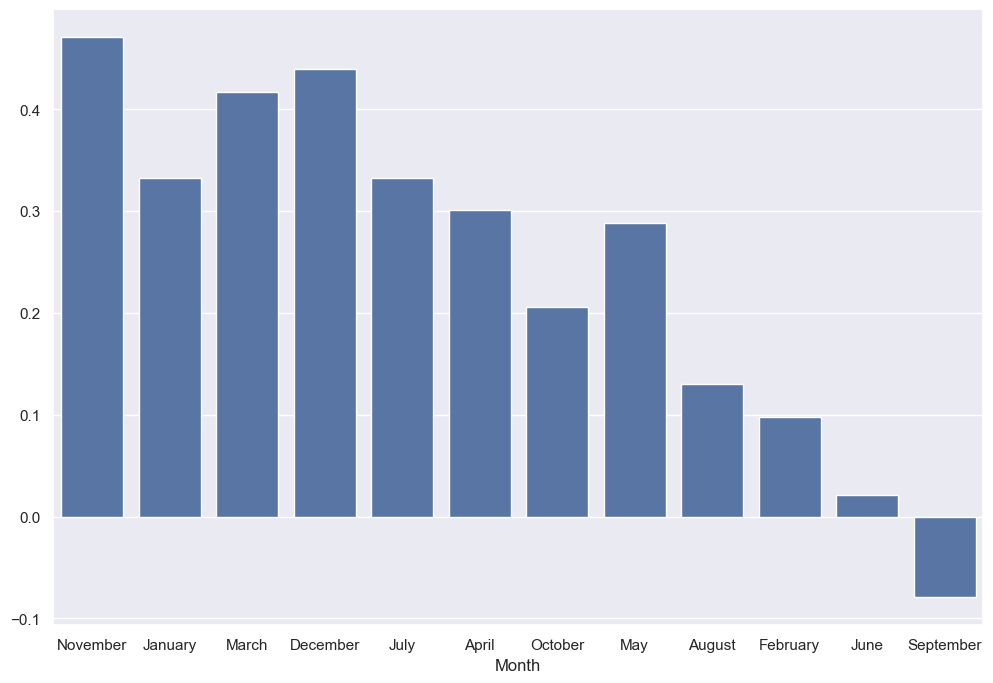

In [136]:
sns.barplot(month_returns_risk,order=month_returns.sort_values(ascending=False).index) # Using same ordering as previous graph we can demonstrate the changes in order